# MuTrans script: untreated

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

datadir = "data/"

In [3]:
adata = sc.read(datadir+'ut_seurat.h5ad')
adata

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 17115 × 22676
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'CellID', 'Class', 'CMO', 'Counts', 'sample_id', 'description', 'Rec', 'Condition', 'batch', 'replicate', 'sizeFactor', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'subsets_linc_sum', 'subsets_linc_detected', 'subsets_linc_percent', 'subsets_ribo_sum', 'subsets_ribo_detected', 'subsets_ribo_percent', 'total', 'Seurat.Phase', 'Seurat.S', 'Seurat.G2M', 'Seurat.Cycle.Score', 'nCount_SCT', 'nFeature_SCT', 'snn_res.0.1', 'seurat_clusters.0.1', 'snn_res.0.2', 'seurat_clusters.0.2', 'snn_res.0.3', 'seurat_clusters.0.3', 'snn_res.0.4', 'seurat_clusters.0.4', 'snn_res.0.5', 'seurat_clusters.0.5', 'snn_res.0.6', 'seurat_clusters.0.6', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig', 'AMT.score', 'AMT.state', 'Freq', 'full_seq', 'BC.14', 'BC.30', 'real_bc44', 'Cluster_Name', 'Coexprs.Sig', 'ADRN.Sig.chapple', 'MES.Sig.chapple', 'INTER.Sig.chapple', 'A

In [4]:
adata.layers["raw_counts"] = adata.raw.X
adata.layers["seurat_lognorm"] = adata.X
adata.X = adata.raw.X

In [5]:
adata.obs = adata.obs[['Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score']]
adata.obsm = []
adata

AnnData object with n_obs × n_vars = 17115 × 22676
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score'
    var: 'features'
    layers: 'raw_counts', 'seurat_lognorm'

In [6]:
# Check adata has raw counts matrix
df = pd.DataFrame.sparse.from_spmatrix(adata.X)
df.head(10)

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    1.0  ...   
1    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    4.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0  ...   
3    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    6.0  ...   
4    0.0    0.0    0.0    0.0    0.0    2.0    0.0    4.0    2.0    1.0  ...   
5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    3.0    1.0  ...   
6    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    5.0  ...   
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    6.0  ...   
8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    4.0  ...   
9    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    4.0  ...   

   22666  22667  22668  22669  22670  22671  22672  22673  22674  22675  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    1.0    0.0    1.0    0.0    0.0    0.0  
5    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0  
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0    0.0  
8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
9    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  

[10 rows x 22676 columns]

## Pre-processing

Quick QC

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

Normalisation

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

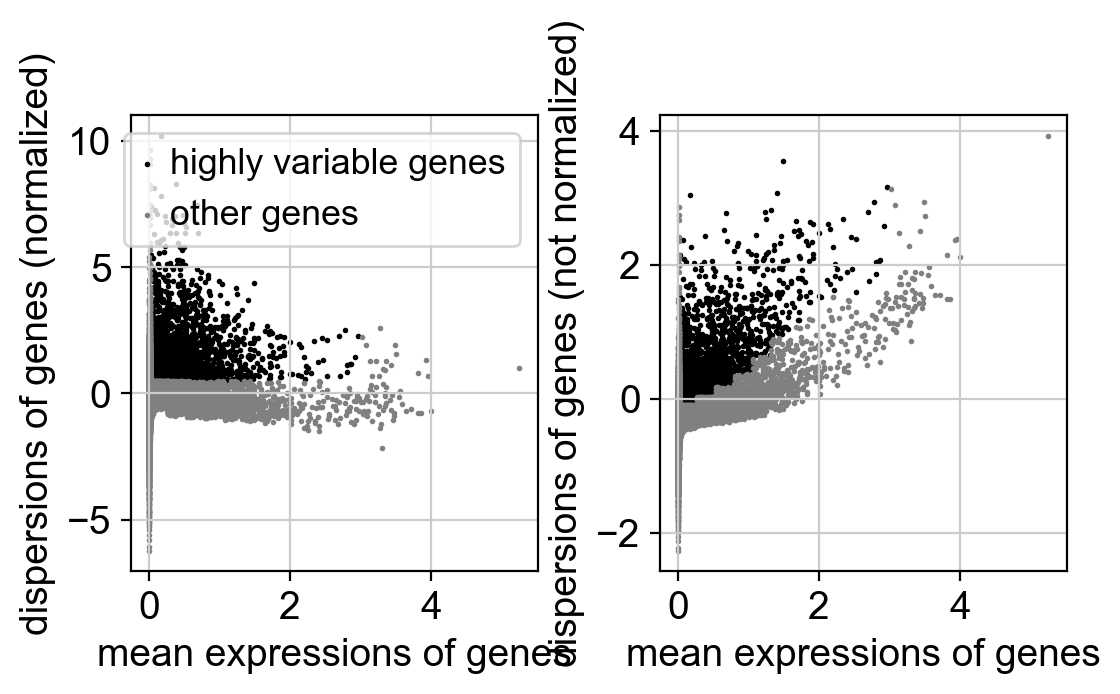

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
# Set .raw attribute of AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata
# Filter for highly variable genes
adata = adata[:, adata.var.highly_variable]

In [11]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df

In [12]:
sc.pp.scale(adata, max_value = 10) # Clips values exceeding sd = 10

Reduced dims

In [13]:
sc.tl.pca(adata, svd_solver = 'arpack')

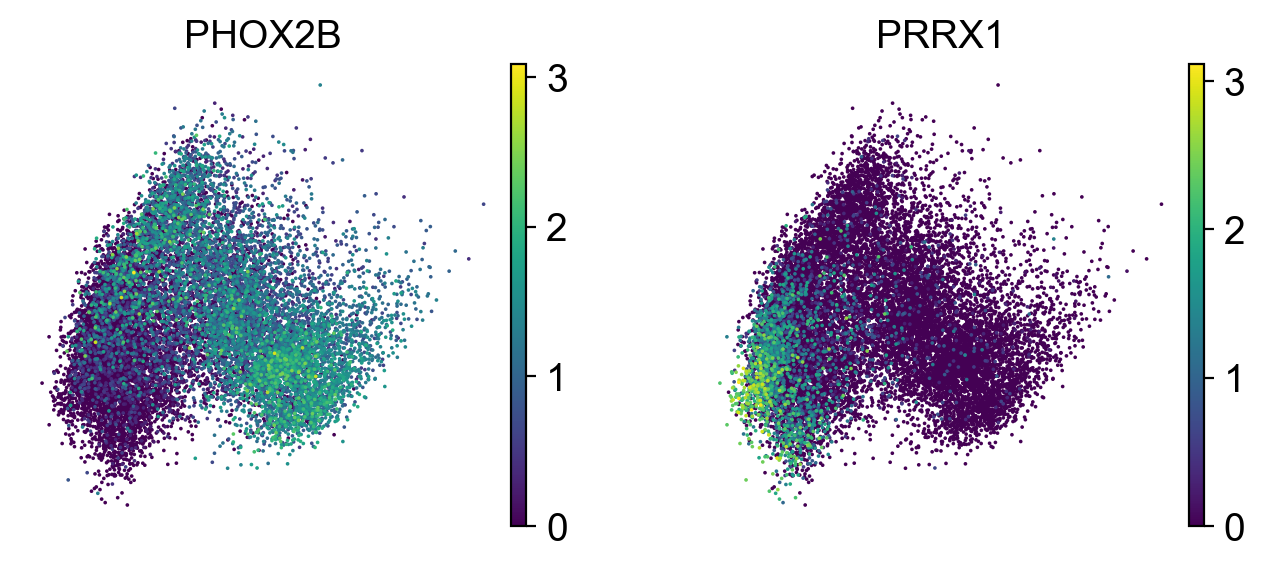

In [14]:
sc.pl.pca(adata, color = ['PHOX2B','PRRX1'])

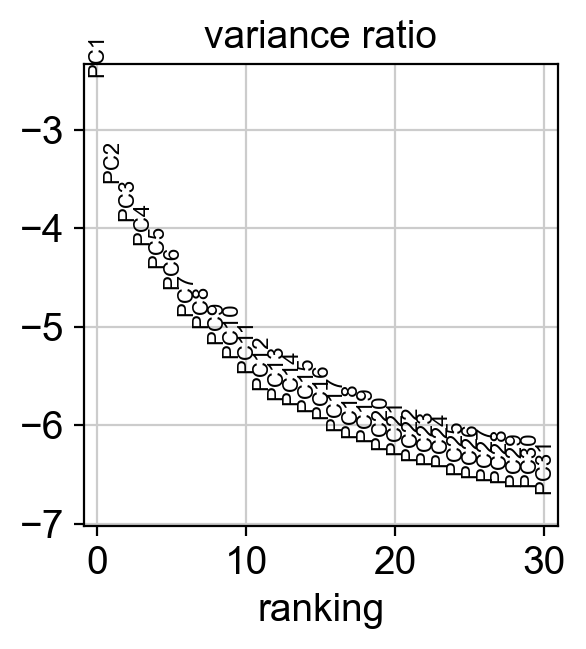

In [15]:
sc.pl.pca_variance_ratio(adata, log = True)

In [16]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1086: NumbaD

In [17]:
sc.tl.umap(adata)

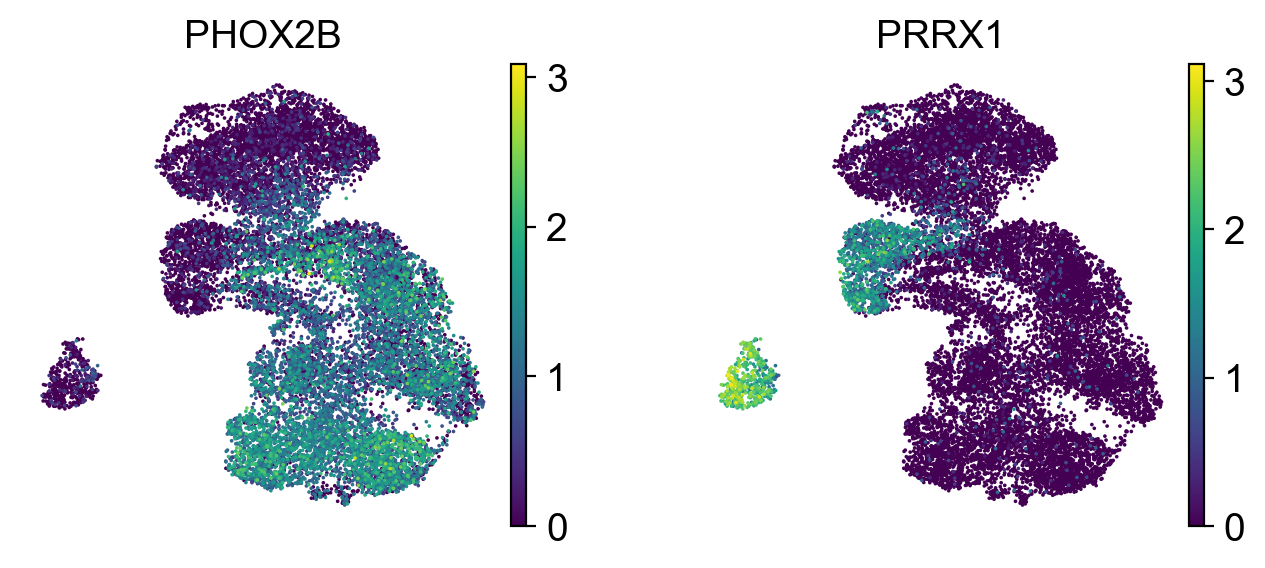

In [18]:
sc.pl.umap(adata, color = ['PHOX2B','PRRX1'])

Clustering

In [19]:
sc.tl.leiden(adata, resolution = 0.1)

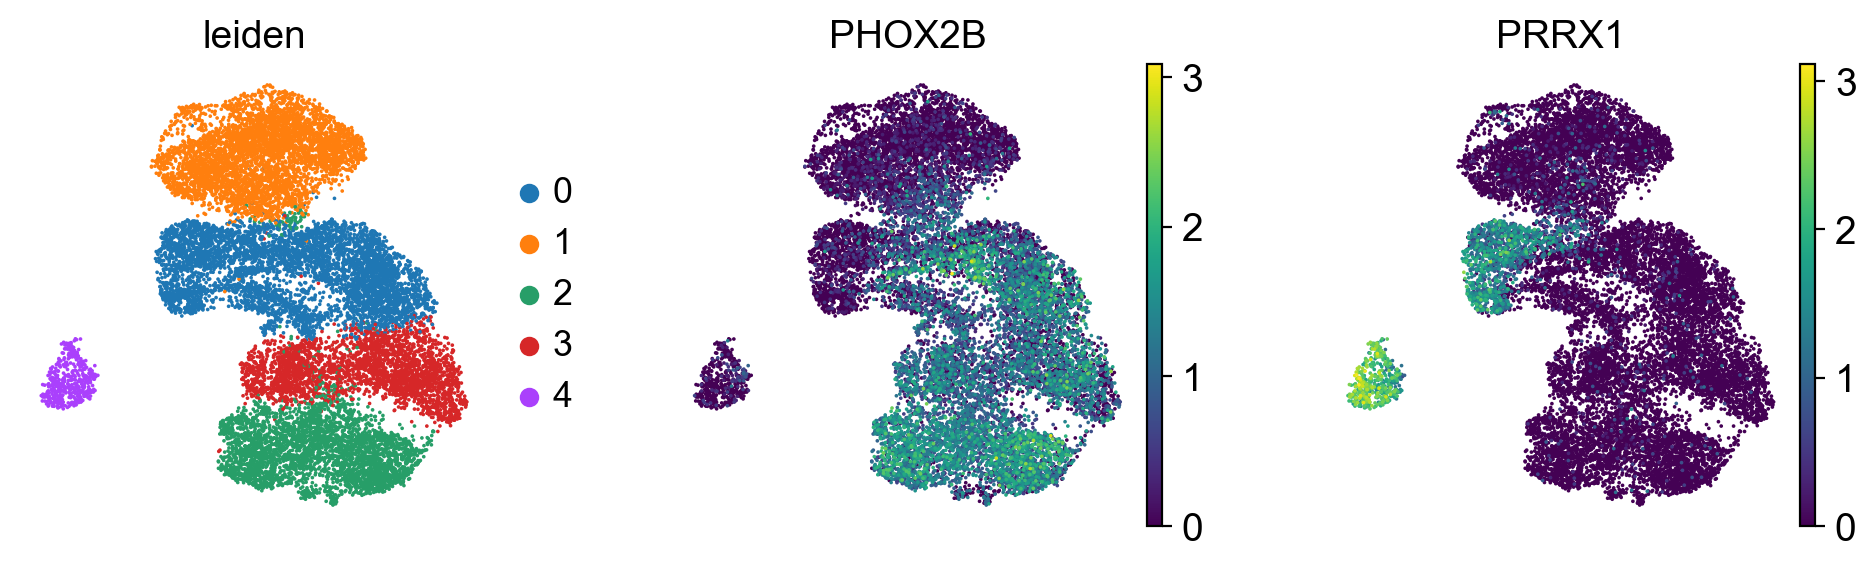

In [20]:
sc.pl.umap(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

In [44]:
adata.write_h5ad(
    datadir+"ut_scanpy.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Marker genes

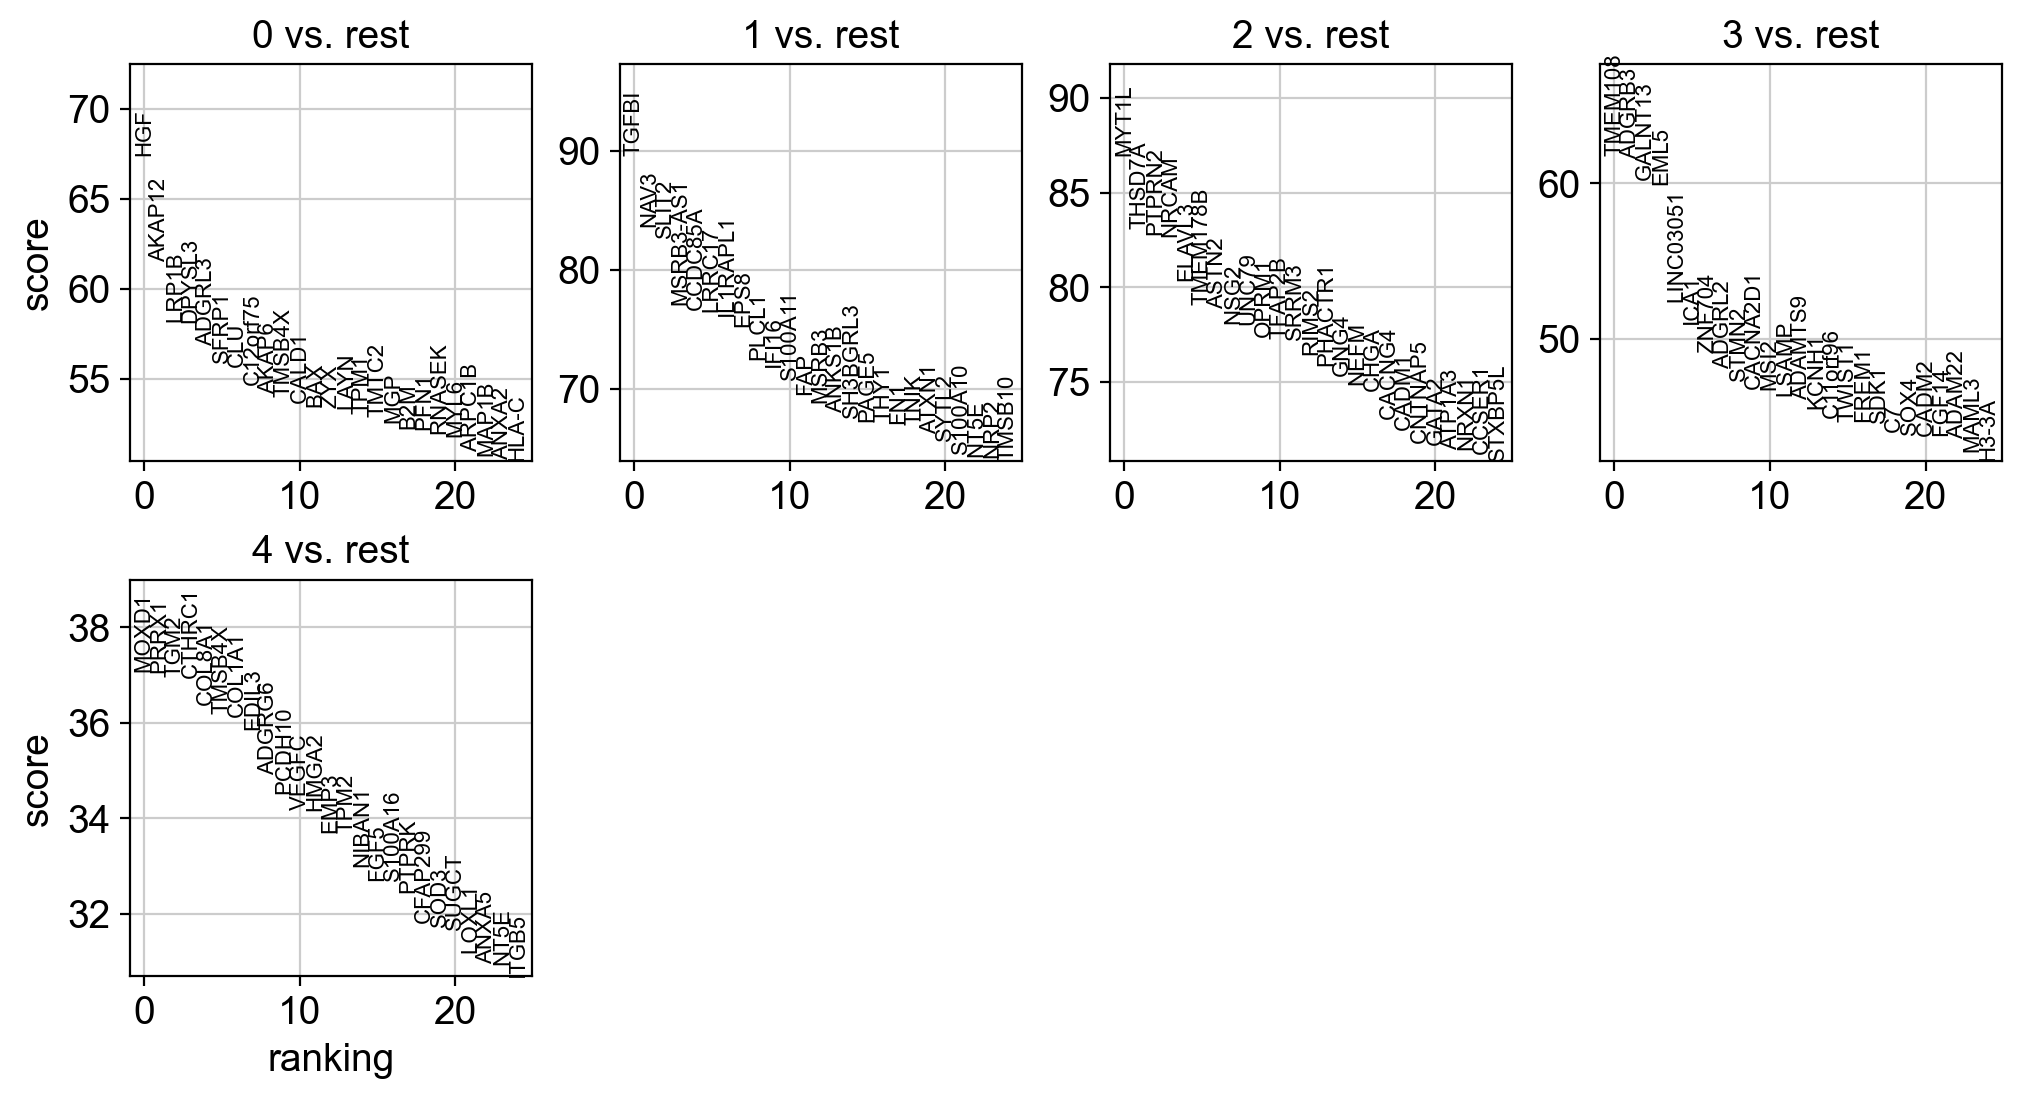

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

PAGA analysis

In [46]:
adata = sc.read(datadir+"ut_scanpy.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


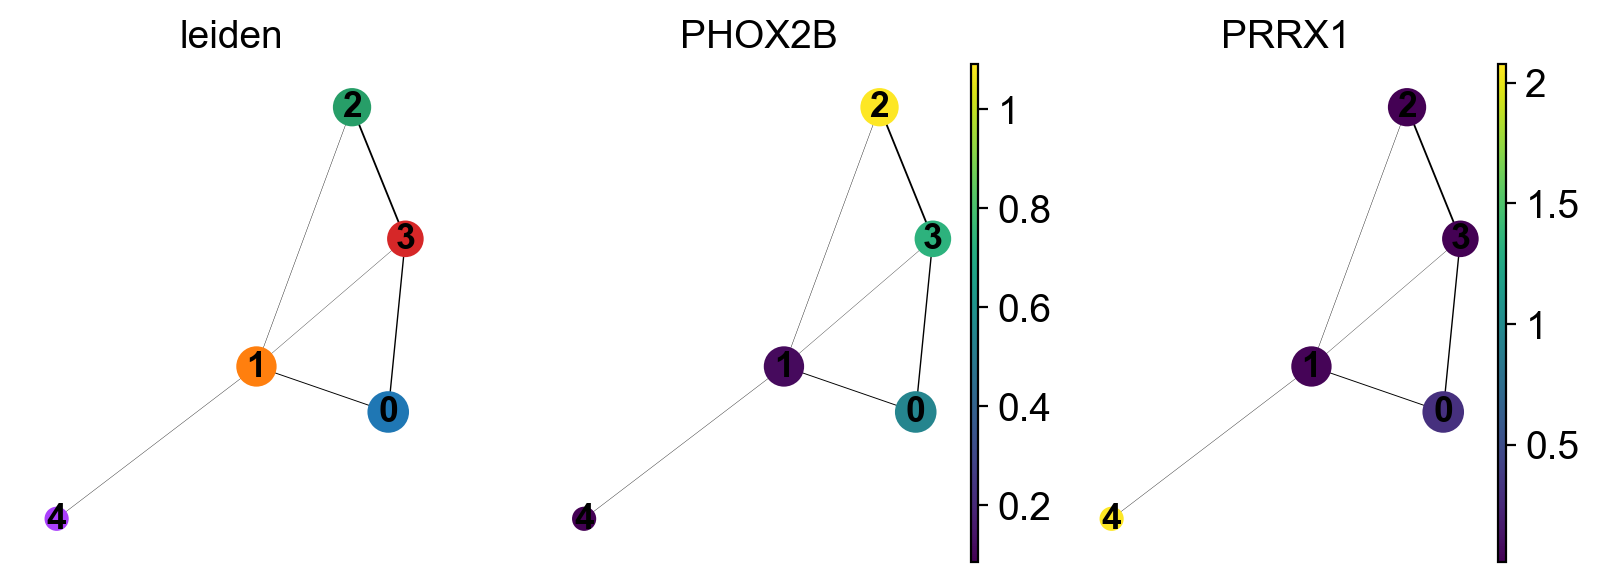

In [47]:
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = ['leiden', 'PHOX2B','PRRX1'])

## Mutrans analysis

In [48]:
sc.tl.tsne(adata, n_pcs = 30)

In [49]:
sc.pp.neighbors(adata, metric = 'cosine', n_neighbors = 60, use_rep = 'X')

In [50]:
adata.write_h5ad(
    datadir+"ut_scanpy_nn.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

Start run from here

In [2]:
plotdir = "../plots/ut/"

In [3]:
adata = sc.read(datadir+"ut_scanpy_nn.h5ad")

/home/echen/.conda/envs/mt_311/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
gc.collect()

31

In [5]:
par = {"choice_distance":"cosine", "K_cluster":5.0, "trials":50, "weight_scale":True, "initial":"pca", "reduce_large_scale":True, "reduce_num_meta_cell":1000.0, "fig_name": plotdir+"dynam_out"} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

Computed P-values 500 of 17115 datapoints...
Computed P-values 1000 of 17115 datapoints...
Computed P-values 1500 of 17115 datapoints...
Computed P-values 2000 of 17115 datapoints...
Computed P-values 2500 of 17115 datapoints...
Computed P-values 3000 of 17115 datapoints...
Computed P-values 3500 of 17115 datapoints...
Computed P-values 4000 of 17115 datapoints...
Computed P-values 4500 of 17115 datapoints...
Computed P-values 5000 of 17115 datapoints...
Computed P-values 5500 of 17115 datapoints...
Computed P-values 6000 of 17115 datapoints...
Computed P-values 6500 of 17115 datapoints...
Computed P-values 7000 of 17115 datapoints...
Computed P-values 7500 of 17115 datapoints...
Computed P-values 8000 of 17115 datapoints...
Computed P-values 8500 of 17115 datapoints...
Computed P-values 9000 of 17115 datapoints...
Computed P-values 9500 of 17115 datapoints...
Computed P-values 10000 of 17115 datapoints...
Computed P-values 10500 of 17115 datapoints...
Computed P-values 11000 of 17115 

In [6]:
adata_mu

AnnData object with n_obs × n_vars = 17115 × 2624
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'attractor', 'entropy'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap', 'da_out', 'land'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'seurat_lognorm'
    obsp: 'connectivities', 'distances'

In [7]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

array([[0.29138987],
       [0.21950643],
       [0.19576741],
       [0.02995682],
       [0.26337947]])

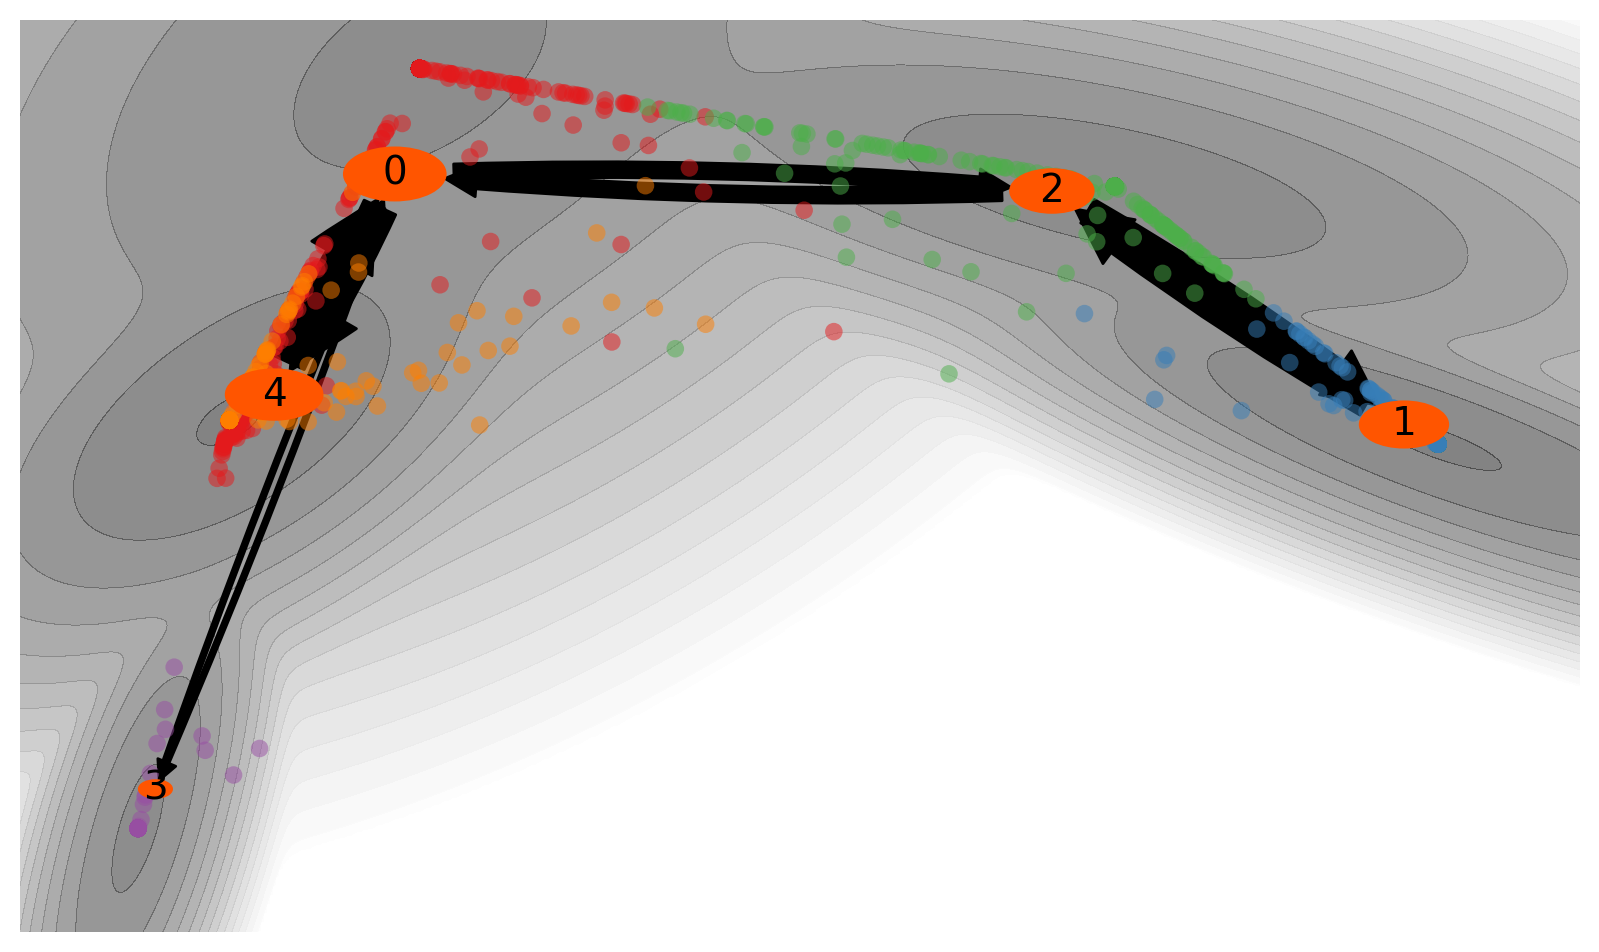

In [8]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point = 40, alpha_point = 0.5, size_text = 15)
plt.savefig(plotdir+"ut_mpft.pdf")
plt.savefig(plotdir+"ut_mpft.png")

MPPT 1 to 3

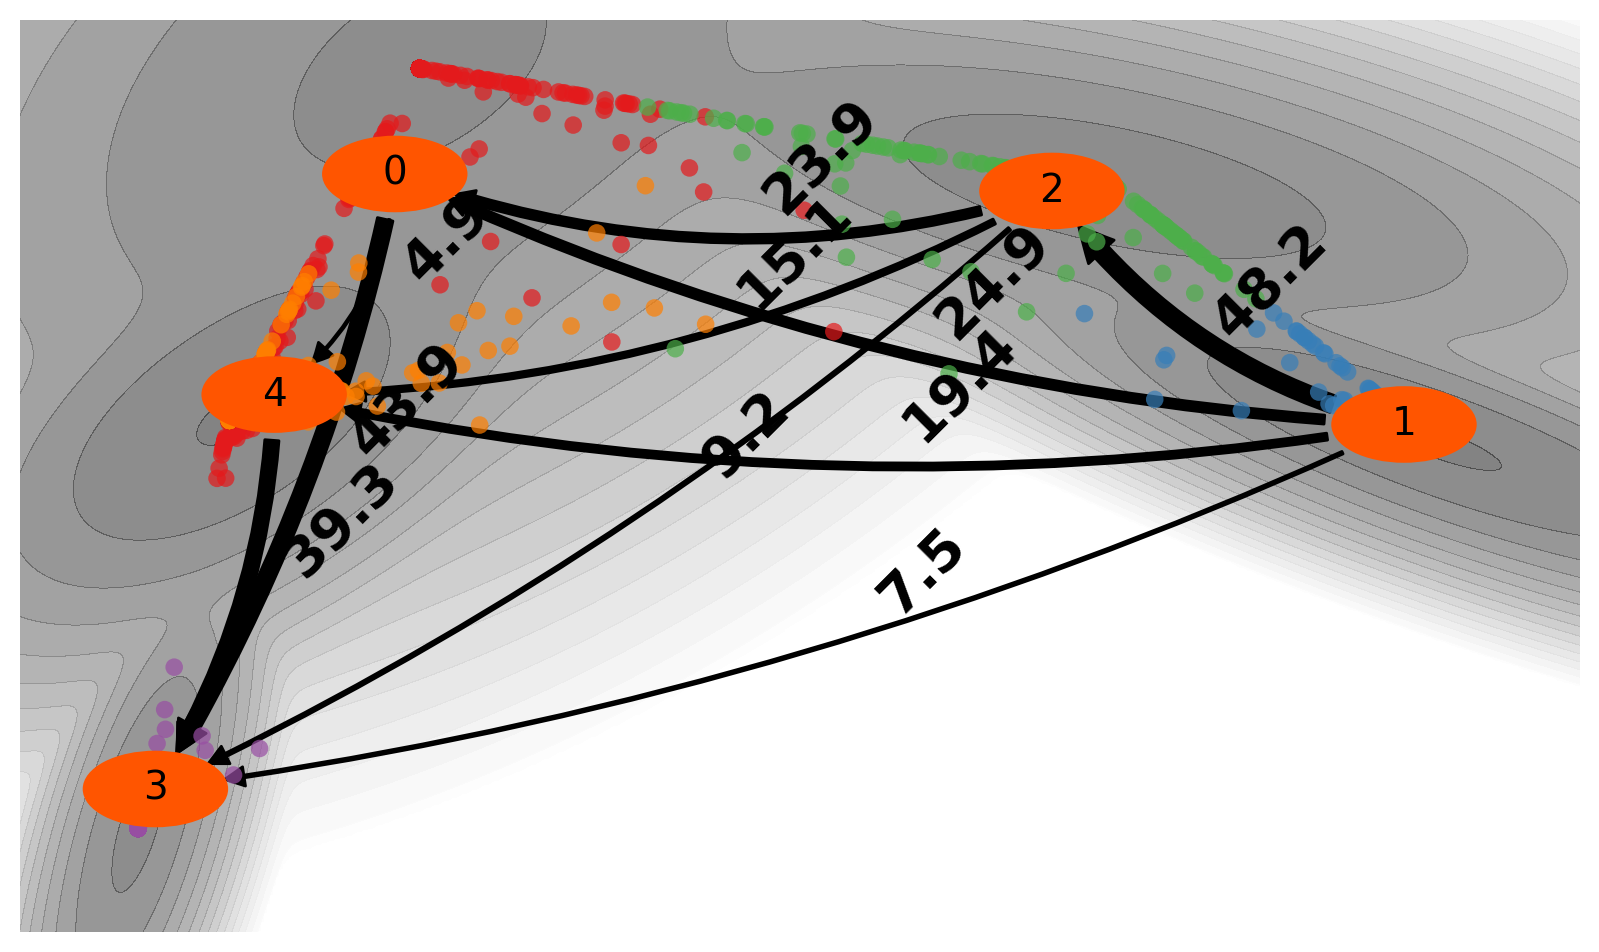

In [9]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1,sf = 3, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"ut_mppt_1_to_3_100.pdf")
plt.savefig(plotdir+"ut_mppt_1_to_3_100.png")

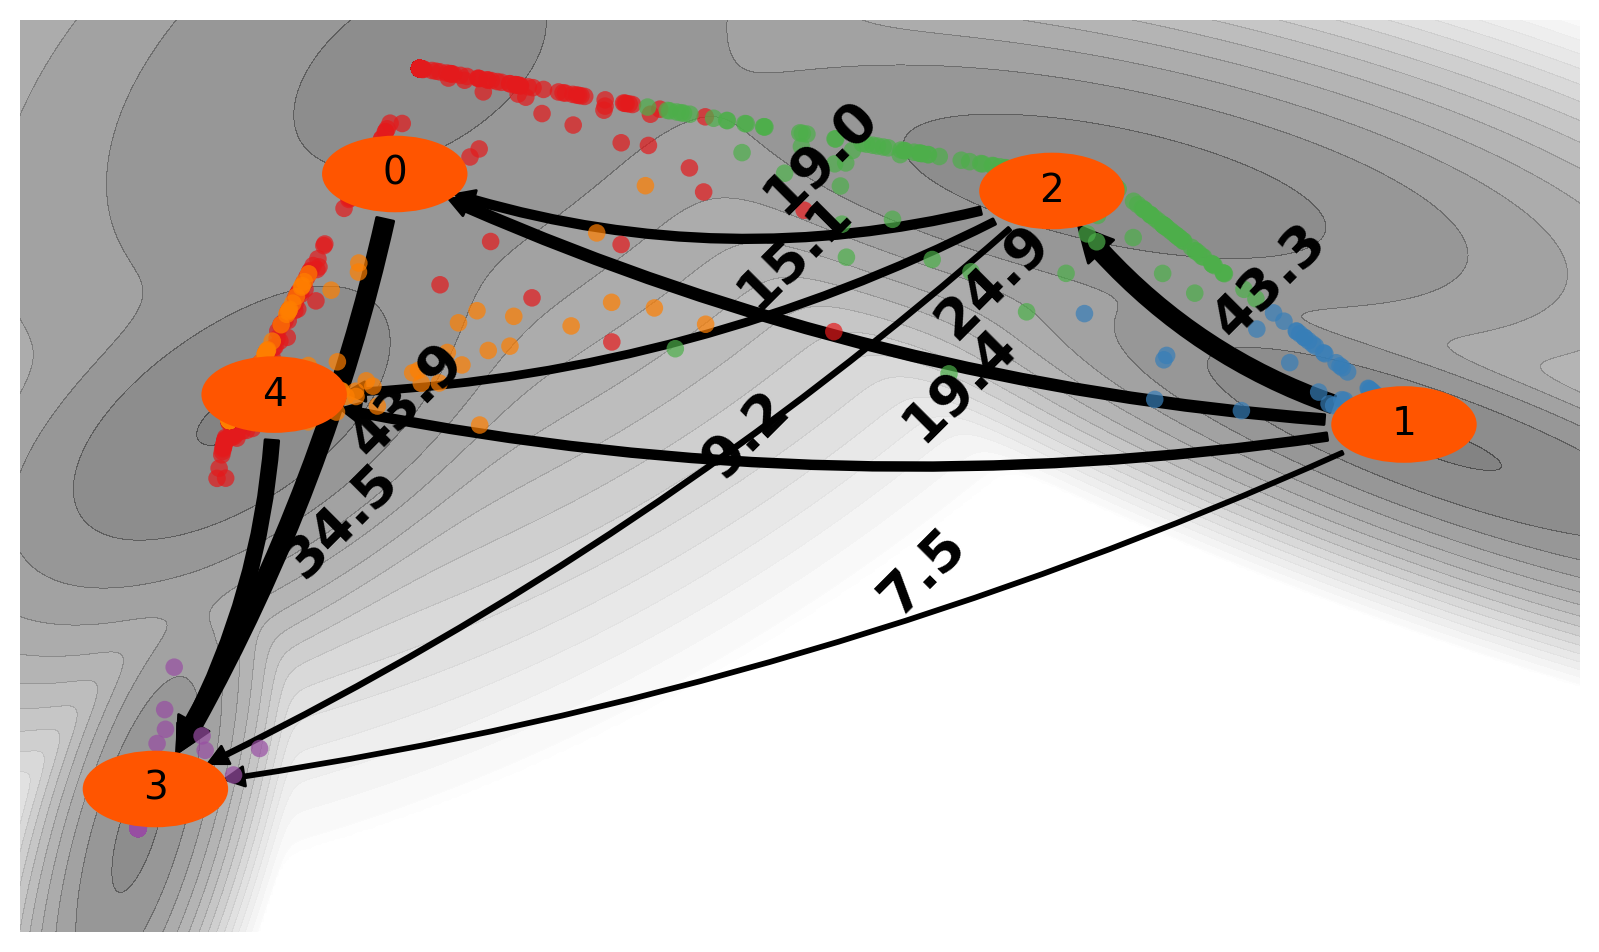

In [10]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1, sf = 3, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"ut_mppt_1_to_3_90.pdf")
plt.savefig(plotdir+"ut_mppt_1_to_3_90.png")

MPPT 1 to 4

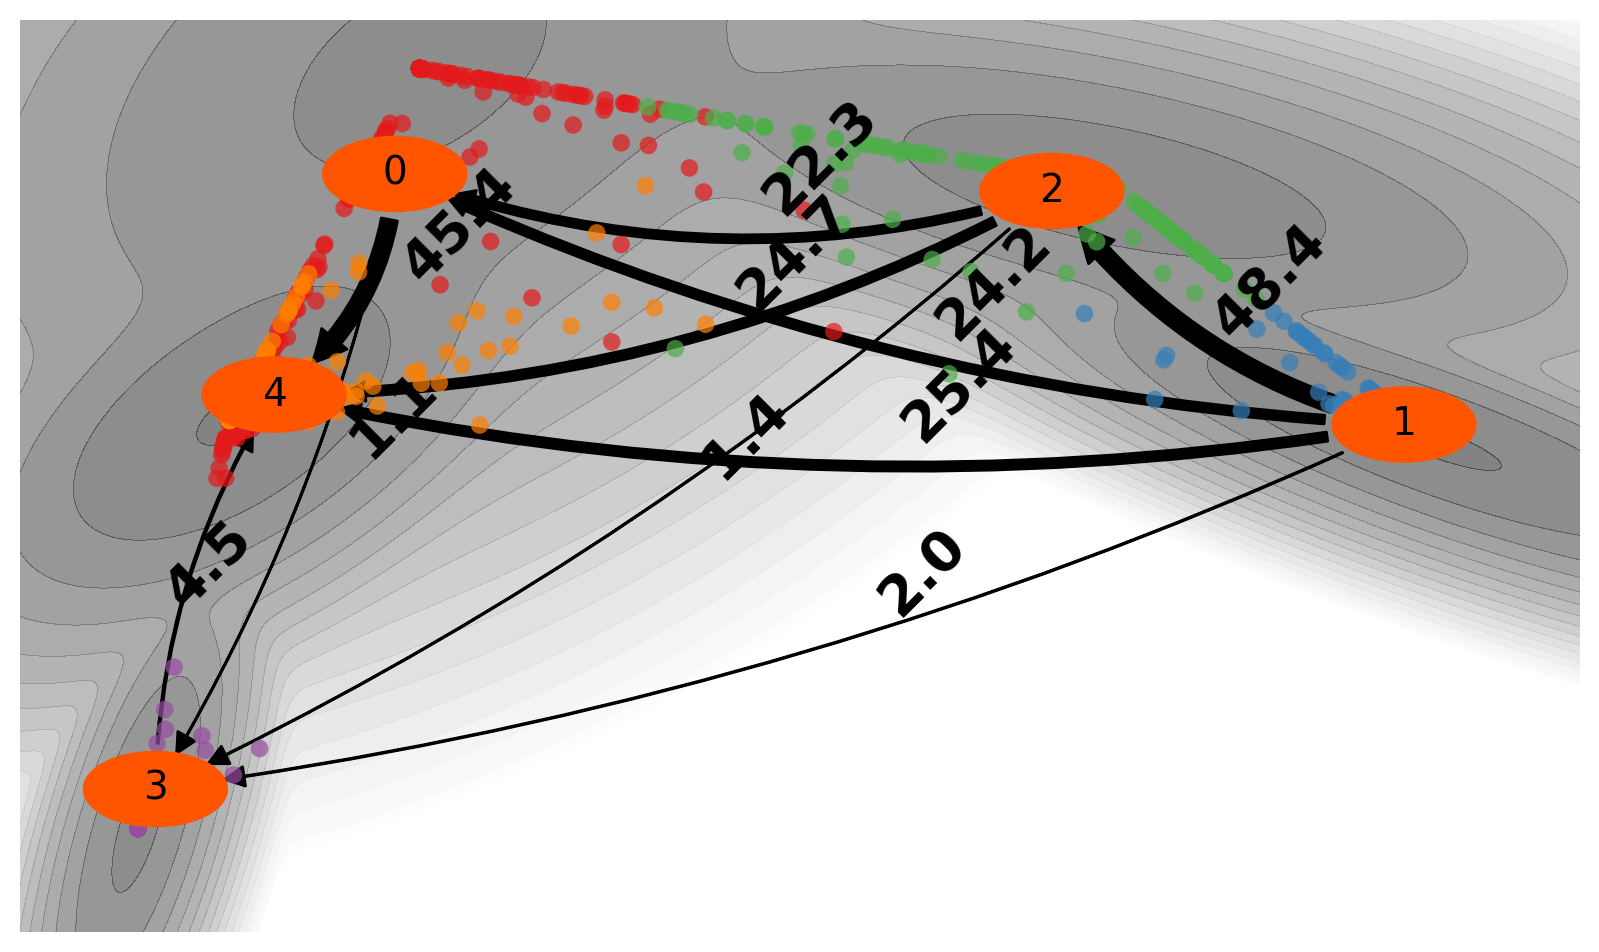

In [11]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1,sf = 4, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"ut_mppt_1_to_4_100.pdf")
plt.savefig(plotdir+"ut_mppt_1_to_4_100.png")

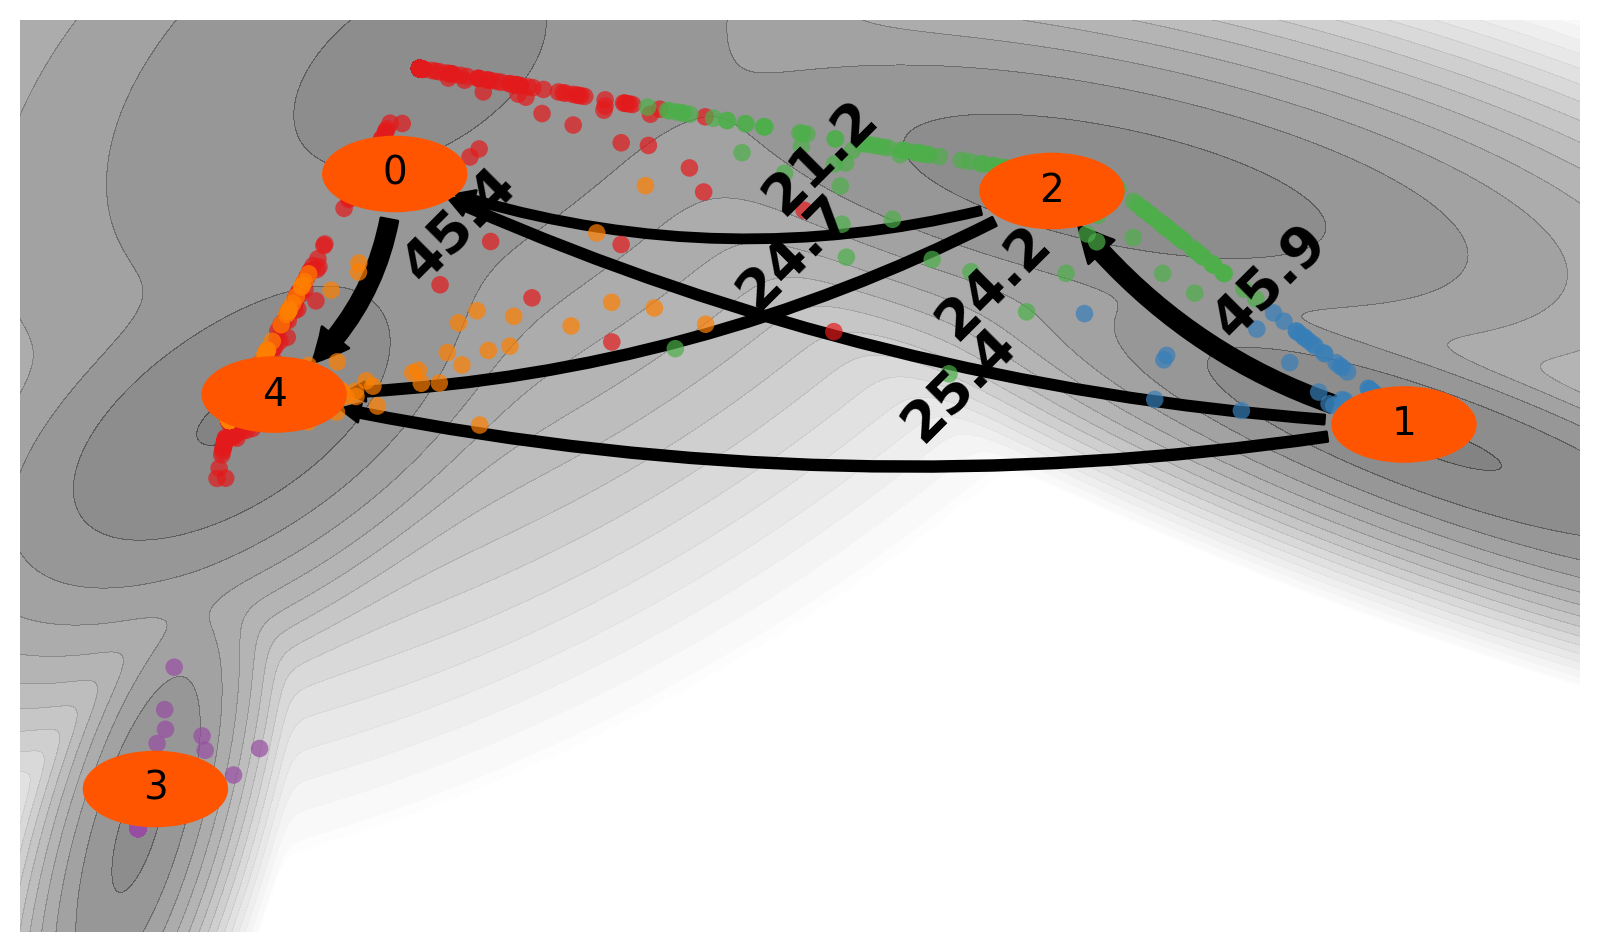

In [12]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1, sf = 4, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"ut_mppt_1_to_4_90.pdf")
plt.savefig(plotdir+"ut_mppt_1_to_4_90.png")

In [13]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

/home/echen/.conda/envs/mt_311/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/echen/.conda/envs/mt_311/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/echen/.conda/envs/mt_311/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/echen/.conda/envs/mt_311/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: Futu

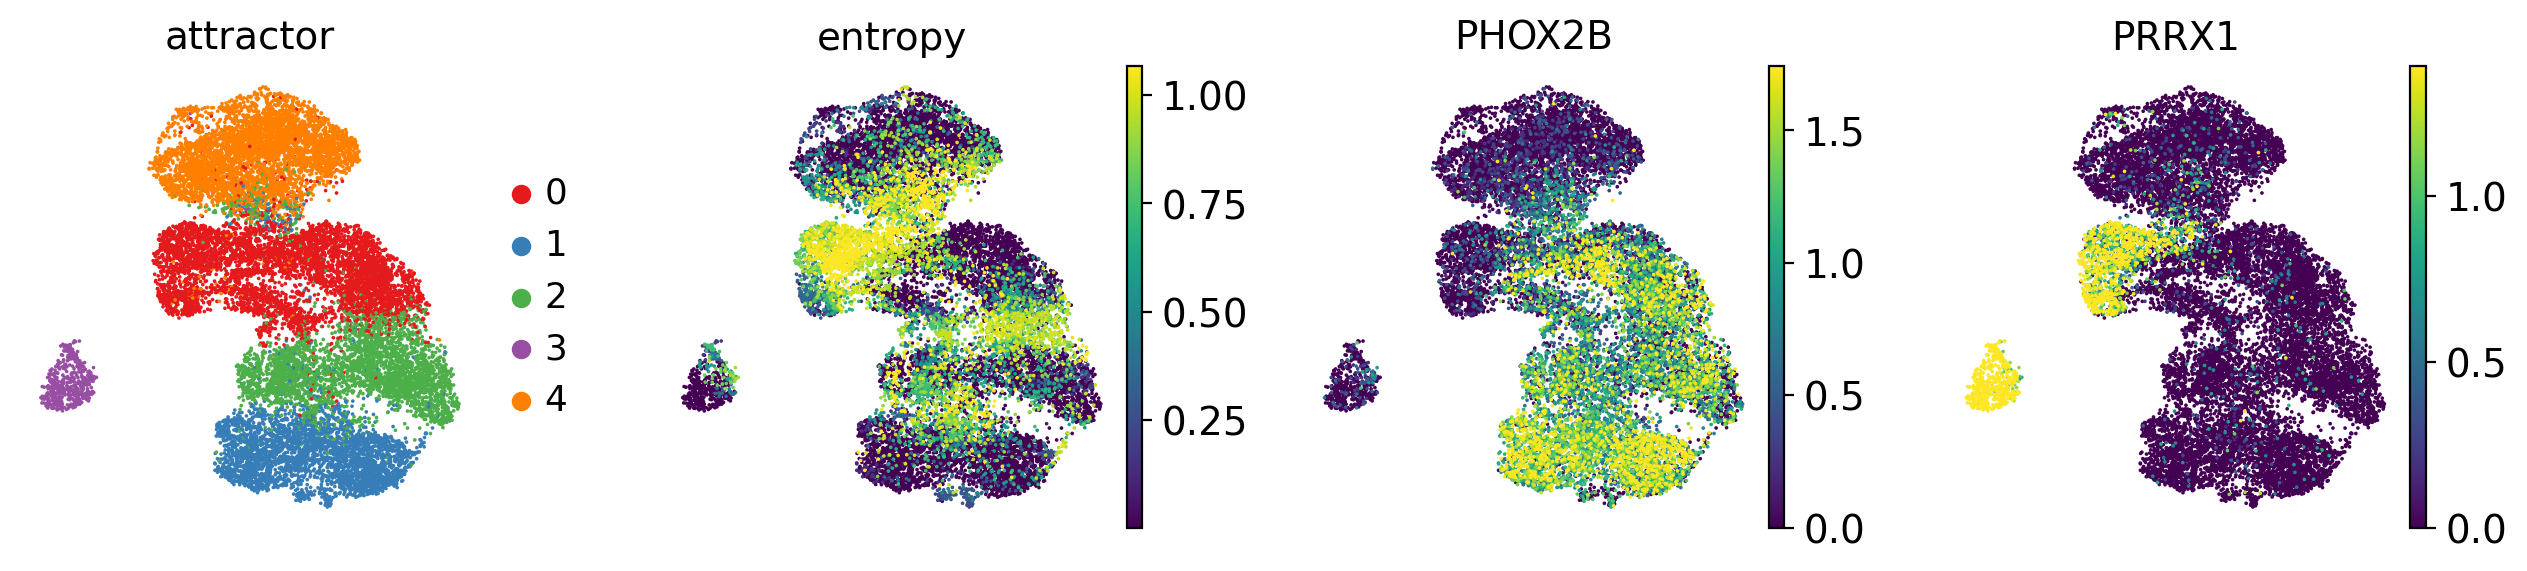

In [14]:
color_palette = sns.color_palette('Set1', 5)
sc.pl.umap(adata_mu, color = ['attractor', 'entropy', 'PHOX2B', 'PRRX1'], vmax = 'p95', palette = color_palette, show = False)
plt.savefig(plotdir+"ut_umap_attractor_entropy.pdf")
plt.savefig(plotdir+"ut_umap_attractor_entropy.png")

In [15]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'ut_mutrans.h5ad')

In [16]:
del adata_mu.uns['da_out']
del adata_mu.uns['land']

In [17]:
adata_mu.write_h5ad(
    datadir+"ut_mutrans_mod.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Violin plots

In [2]:
plotdir = "../plots/ut/"

In [2]:
adata_mu = sc.read(datadir+'ut_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 6)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [26]:
land = adata_mu.uns['land']
land

{'grid_x': array([[-6.15869628e+01, -6.13157189e+01, -6.10444750e+01,
         -6.07732312e+01, -6.05019873e+01, -6.02307434e+01,
         -5.99594996e+01, -5.96882557e+01, -5.94170118e+01,
         -5.91457679e+01, -5.88745241e+01, -5.86032802e+01,
         -5.83320363e+01, -5.80607924e+01, -5.77895486e+01,
         -5.75183047e+01, -5.72470608e+01, -5.69758169e+01,
         -5.67045731e+01, -5.64333292e+01, -5.61620853e+01,
         -5.58908415e+01, -5.56195976e+01, -5.53483537e+01,
         -5.50771098e+01, -5.48058660e+01, -5.45346221e+01,
         -5.42633782e+01, -5.39921343e+01, -5.37208905e+01,
         -5.34496466e+01, -5.31784027e+01, -5.29071588e+01,
         -5.26359150e+01, -5.23646711e+01, -5.20934272e+01,
         -5.18221834e+01, -5.15509395e+01, -5.12796956e+01,
         -5.10084517e+01, -5.07372079e+01, -5.04659640e+01,
         -5.01947201e+01, -4.99234762e+01, -4.96522324e+01,
         -4.93809885e+01, -4.91097446e+01, -4.88385007e+01,
         -4.85672569e+01, -4.8

In [25]:
import numpy as np
import pandas as pd

grid_x_df = pd.DataFrame(land['grid_x'], columns=[f'grid_x_{i}' for i in range(land['grid_x'].shape[1])])
grid_y_df = pd.DataFrame(land['grid_y'], columns=[f'grid_y_{i}' for i in range(land['grid_y'].shape[1])])
land_df = pd.DataFrame(land['land'], columns=[f'land_{i}' for i in range(land['land'].shape[1])])
land_cell_df = pd.DataFrame(land['land_cell'], columns=['land_cell'])
trans_coord_df = pd.DataFrame(land['trans_coord'], columns=['trans_coord_x', 'trans_coord_y'])

export_df = pd.concat([grid_x_df, grid_y_df, land_df, land_cell_df, trans_coord_df], axis=1)

export_df.to_csv('land_data_export.csv', index=False)


In [13]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2,
    adata_mu.obs['attractor'] == 3
]

outputs = [
    '1', '2', '4', '3'
]

In [14]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [24]:
energy_pal = {
    '1' : color_palette[0],
    '2' : color_palette[1],
    '3' : color_palette[3],
    '4' : color_palette[2]
}

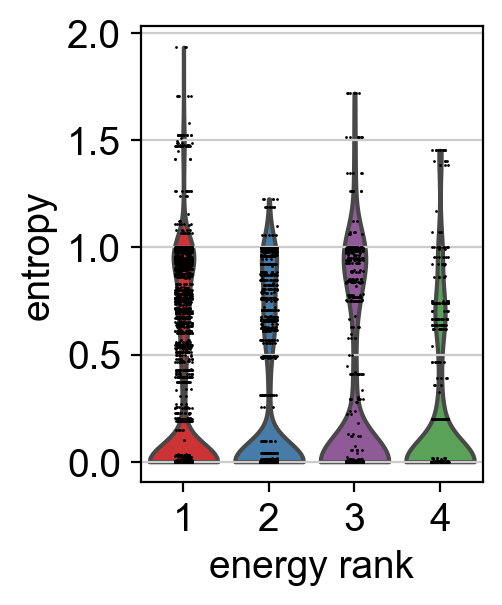

In [25]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = 'entropy', groupby='energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"ut_v2_violin_attractor_entropy_ranked.pdf")
plt.savefig(plotdir+"ut_v2_violin_attractor_entropy_ranked.png")

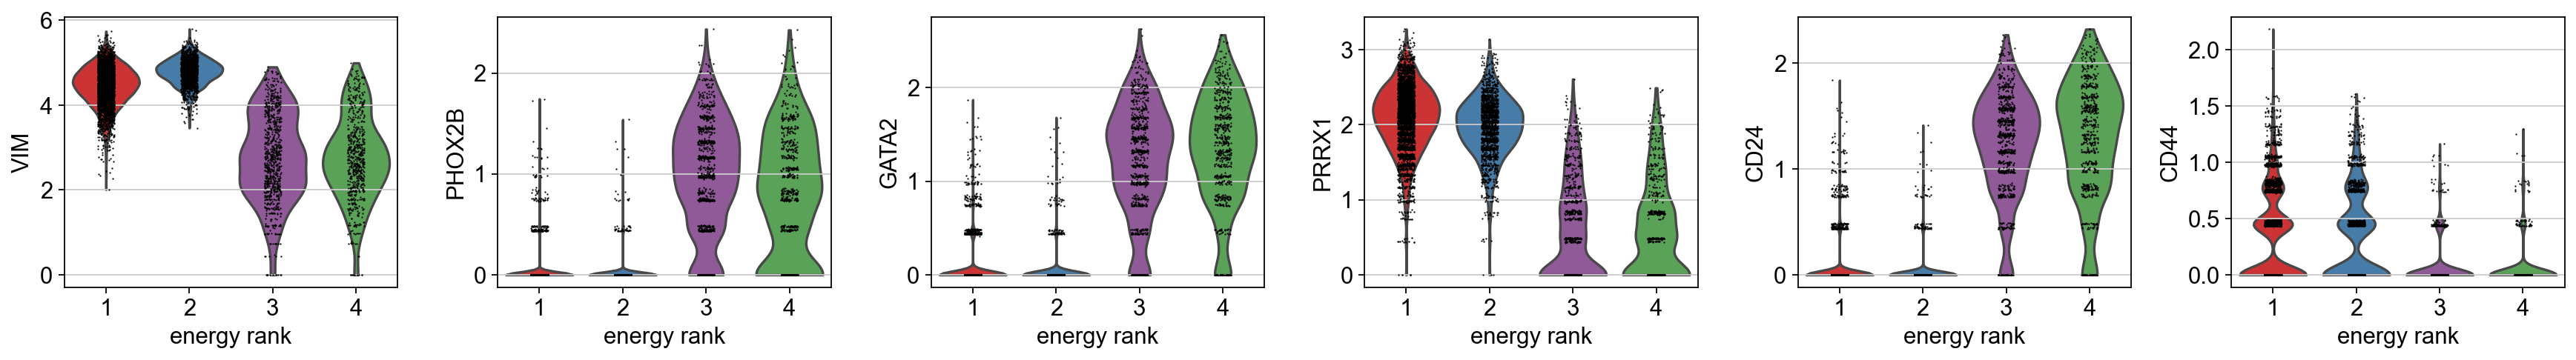

In [26]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"ut_v2_violin_markers_ranked.pdf")
plt.savefig(plotdir+"ut_v2_violin_markers_ranked.png")

In [23]:
adata_mu.write_h5ad(
    datadir+"ut_v2_mutrans_ranked.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)